# Анализ рынка недвижимости в городах: Усть-Каменогорск, Астана и Алматы

Данное исследование поможет ... 
1. написать про города
2. ожидание
3. что это даст

In [1]:
%matplotlib inline

import locale
locale.setlocale(locale.LC_ALL, ('RU', 'UTF8'))
import os
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#warnings.filterwarnings('ignore')

import geopandas as gpd
import folium
from folium import plugins

## 1. Загрузка данных

In [2]:
path = os.path.join(os.getcwd(), "new_csv")
almaty_directory = glob.glob(os.path.join(path, "almaty", "*.csv"))
astana_directory = glob.glob(os.path.join(path, "astana", "*.csv"))
ustkamenogorsk_directory = glob.glob(os.path.join(path, "ust-kamenogorsk", "*.csv"))

almaty = pd.concat((pd.read_csv(csv_file, quotechar='|') for csv_file in almaty_directory))
astana = pd.concat((pd.read_csv(csv_file, quotechar='|') for csv_file in astana_directory))
ust_kamenogorsk = pd.concat((pd.read_csv(csv_file, quotechar='|') for csv_file in ustkamenogorsk_directory))

In [3]:
#find wrong parsed values
almaty.room_count.unique()

array([  4,   1,   9,   2,   5,   3,   7,   6,   8,  10,  11,  12,  20,
        49, 160,  32,  34, 250,  73,  19,  57,  33,  15,  59])

In [4]:
almaty.head()

,id,date,city,address,lat,lon,price,view_count,room_count,image_count,...,phone,inet_type,furniture,floor_type,security,priv_dorm,parking,room_height,complex,is_pledged
0,27915992,08.01.2018,"Алматы, Бостандыкский р-н",Навои 208,43.206766,76.884964,64000000,3,4,8,...,NaN,NaN,частично меблирована,NaN,NaN,нет,NaN,NaN,Шахристан,0
1,27808874,08.01.2018,"Алматы, Ауэзовский р-н",Бауыржана Момышулы — Толе би,43.237610,76.829618,10500000,46,1,2,...,отдельный,проводной,NaN,линолеум,домофон,нет,рядом охраняемая стоянка,NaN,NaN,0
2,27445667,08.01.2018,"Алматы, Медеуский р-н",проспект Достык 162 — Жолдасбекова,43.233735,76.959820,150000000,243,9,26,...,NaN,NaN,пустая,NaN,"охрана, кодовый замок, видеонаблюдение",нет,паркинг,6 м,Алматы Тауэрс,0
3,27915990,08.01.2018,"Алматы, Бостандыкский р-н",Абая 20/1,43.240096,76.943022,17000000,2,2,5,...,NaN,NaN,частично меблирована,ламинат,NaN,нет,NaN,NaN,NaN,0
4,27915989,08.01.2018,"Алматы, Бостандыкский р-н",Тимирязева,43.226572,76.918605,8700000,5,2,12,...,NaN,NaN,NaN,линолеум,NaN,нет,рядом охраняемая стоянка,2.5,NaN,0


## 2. Обработка данных

Для начала данные необходимо **получить уникальные объявления**, т.е. выбрать с наибольшим количеством просмотров из дублирующихся.

In [5]:
almaty = almaty[almaty.groupby('id')['view_count'].transform(max) == almaty['view_count']]
astana = astana[astana.groupby('id')['view_count'].transform(max) == astana['view_count']]
ust_kamenogorsk = ust_kamenogorsk[ust_kamenogorsk.groupby('id')['view_count'].transform(max) == ust_kamenogorsk['view_count']]

Получим **цену за кв. метр**, исходя из цены на квартиру и ее площади.

In [6]:
almaty['1m_price'] = almaty['price'] / almaty['area_total']
astana['1m_price'] = astana['price'] / astana['area_total']
ust_kamenogorsk['1m_price'] = ust_kamenogorsk['price'] / ust_kamenogorsk['area_total']

Объединим объявления в **общий Data Frame**

In [7]:
cities = [almaty, astana, ust_kamenogorsk]
cities_data = pd.concat(cities)

Отчистим **строки с NaN-значения** в обязательных полях

In [8]:
cities_data = cities_data[(pd.notnull(cities_data['price']))
                          & (pd.notnull(cities_data['room_count']))
                          & (pd.notnull(cities_data['building_year']))
                          & (pd.notnull(cities_data['area_total']))
                          & (pd.notnull(cities_data['lat']))
                          & (pd.notnull(cities_data['lon']))]

Получим **дни недели** по дате

In [9]:
#cities_data['week_of_day'] = pd.to_datetime(cities_data['date'], format='%d.%m.%Y').dt.weekday_name

**Ознакомимся с признаками объявлений.**

In [10]:
cities_data.columns

Index(['id', 'date', 'city', 'address', 'lat', 'lon', 'price', 'view_count',
       'room_count', 'image_count', 'comment_count', 'color', 'is_owner',
       'is_urgent', 'building_type', 'building_year', 'floor',
       'building_floors', 'area_total', 'area_living', 'area_kitchen',
       'renovation', 'toilet', 'balcony', 'balcony_glass', 'door', 'phone',
       'inet_type', 'furniture', 'floor_type', 'security', 'priv_dorm',
       'parking', 'room_height', 'complex', 'is_pledged', '1m_price'],
      dtype='object')

1. **id** – идентификатор объявления
2. **date** – дата подачи объявления
3. **city*** – город и район
4. **address** – адрес, по которому находится жильё
5. **lat*** – географическая широта
6. **lon*** – географическая долгота
7. **price*** – стоимость жилья
8. **view_count** – количество просмотров объявления
9. **room_count*** – количество комнат
10. **image_count** – количество изображений в объявлении
11. **comment_count** – количество комментариев к объявлению
12. **color** – цвет объявления
13. **is_owner** – продавец жилья
14. **is_urgent** – срочность продажи
15. **building_type** – тип дома
16. **building_year*** – год постройки
17. **floor** – этаж, на котором находится жилье
18. **building_floors** – количество этажей в доме
19. **area_total*** – общая площадь
20. **area_living** – жилая площадь
21. **area_kitchen** – площадь кухни
22. **renovation** – состояние жилья
23. **toilet** – тип санузла
24. **balcony** – тип балкона
25. **balcony_glass** – остеклённость балкона
26. **door** – тип входной двери
27. **phone** – тип телефона
28. **inet_type** – тип интернета
29. **furniture** – наличие мебели
30. **floor_type** – тип пола
31. **security** – безопасность
32. **priv_dorm** – в прив. общежитии
33. **parking** – парковка
34. **room_height** – высота потолков
35. **complex** – жилой комплекс
36. **is_pledged** – под залогом
37. **1m_price** – цена за 1 кв. метр

In [11]:
cities_data['price'].describe()

count    3.018930e+05
mean     2.395813e+07
std      2.773918e+07
min      5.200000e+03
25%      1.332000e+07
50%      1.740000e+07
75%      2.550000e+07
max      3.424140e+09
Name: price, dtype: float64

### Корелляция признаков

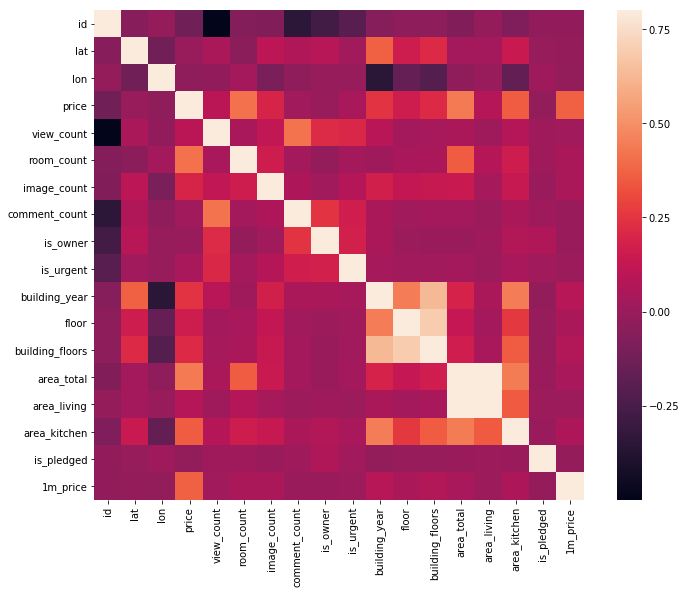

In [12]:
corrmat = cities_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### Средняя цена за кв. метр в разрезе количества комнат

[Text(0,0.5,'КСредняя цена за кв. метр, ₸'), Text(0.5,0,'Количество комнат')]

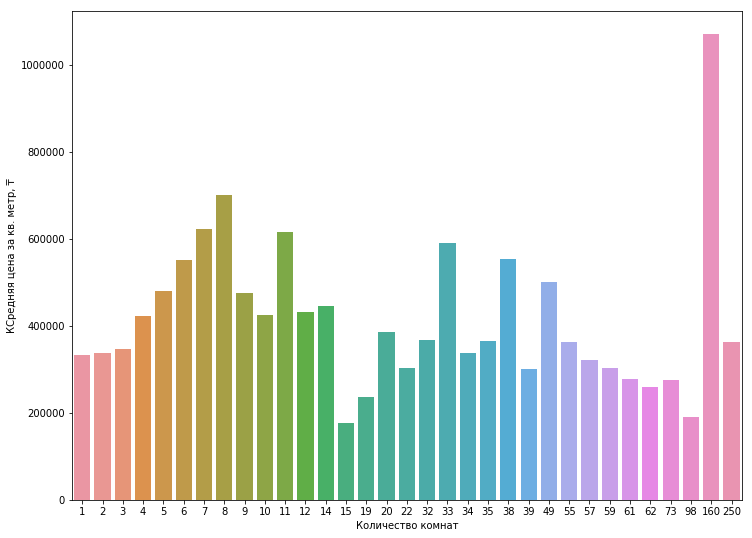

In [13]:
average_1m_price_per_rooms = cities_data[['room_count', '1m_price']].groupby(['room_count'],as_index=False).mean()

f, ax = plt.subplots(figsize=(12, 9))
bar = sns.barplot(x='room_count', y='1m_price', data=average_1m_price_per_rooms)
bar.set(xlabel='Количество комнат', ylabel='КСредняя цена за кв. метр, ₸')

### Количество комнат в продаваемой недвижимости

(-1.1174603162018453,
 1.1150050852874338,
 -1.1198468714391905,
 1.1009450891161519)

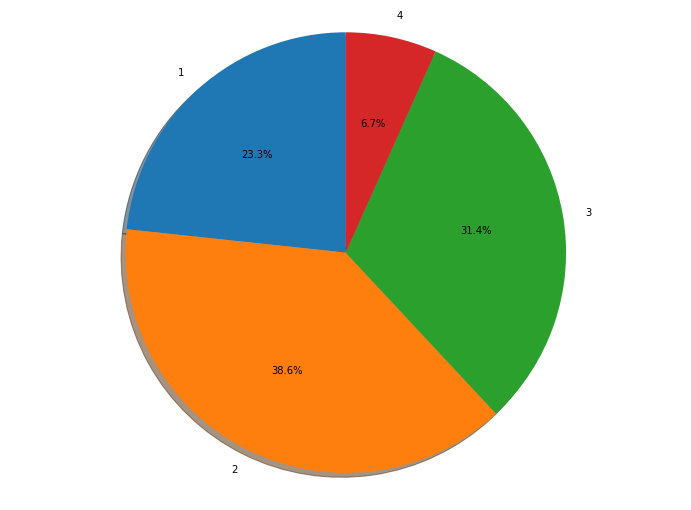

In [14]:
room_count = cities_data.groupby(['room_count']).size().reset_index(name='counts')
one_percent = room_count['counts'].sum() / 100
#other_rooms = room_count[room_count['counts'] <= one_percent]
room_count = room_count[room_count['counts'] > one_percent]
#room_count = room_count.append({'room_count': 'остальные', 'counts': other_rooms['counts'].sum()}, ignore_index=True)

f, ax = plt.subplots(figsize=(12, 9))
ax.pie(room_count['counts'], labels=room_count['room_count'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

In [15]:
#weekday_count = cities_data[['date', 'week_of_day']].groupby(['date']).size().reset_index(name='counts')
#weekday_count['week_of_day'] = pd.to_datetime(weekday_count['date'], format='%d.%m.%Y').dt.weekday_name
#weekday_count.groupby(['week_of_day']).mean()
#f, ax = plt.subplots(figsize=(12, 9))
#bar = sns.barplot(x='counts', y='week_of_day', data=weekday_count)
#bar.set(xlabel='Количество комнат', ylabel='КСредняя цена за кв. метр, ₸')

### Цены на квартиры в разрезе количества комнат

[(10, 300000000)]

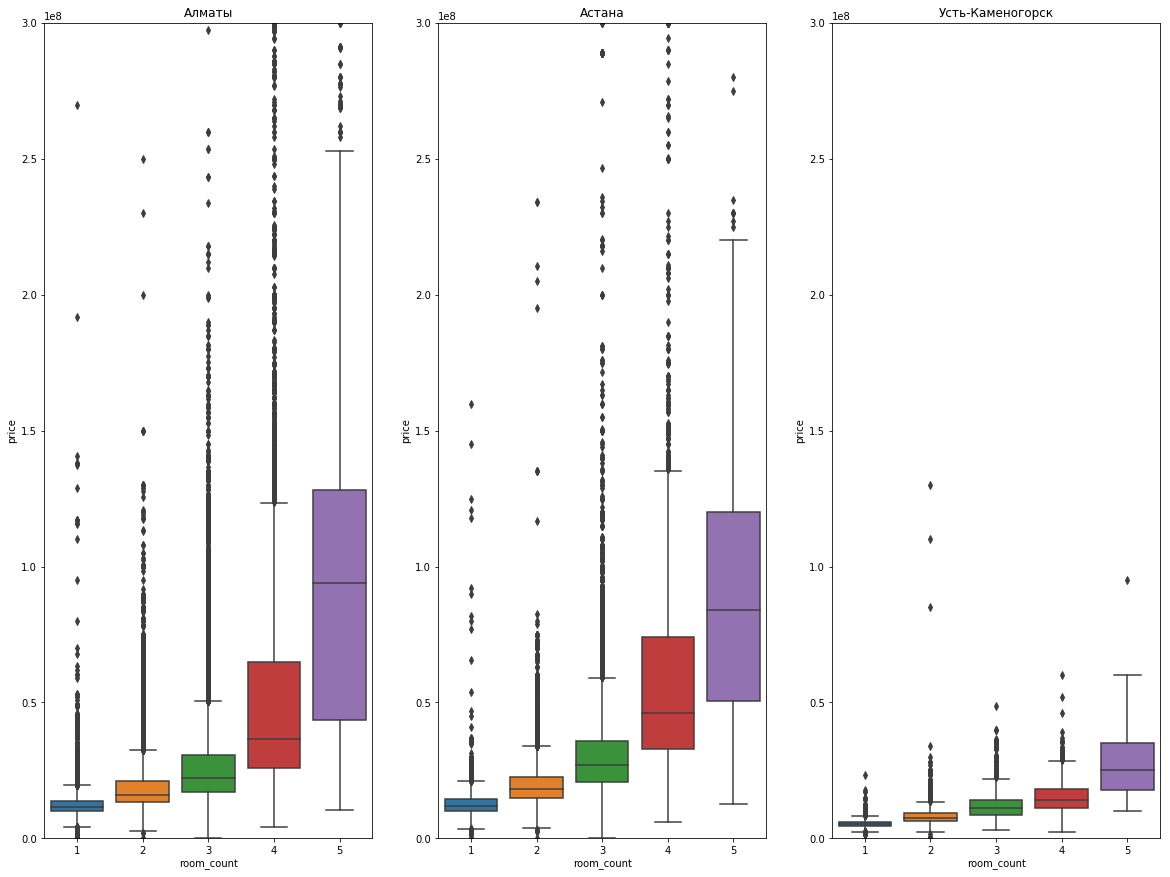

In [16]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(20,15))

almaty_box = sns.boxplot(x='room_count', y='price', data=almaty[almaty['room_count'] < 6], ax=axis1)
almaty_box.set_title('Алматы')
almaty_box.set(ylim=(10, 300000000))

astana_box = sns.boxplot(x='room_count', y='price', data=astana[astana['room_count'] < 6], ax=axis2)
astana_box.set_title('Астана')
astana_box.set(ylim=(10, 300000000))

ust_kamenogorsk_box = sns.boxplot(x='room_count', y='price', data=ust_kamenogorsk[ust_kamenogorsk['room_count'] < 6], ax=axis3)
ust_kamenogorsk_box.set_title('Усть-Каменогорск')
ust_kamenogorsk_box.set(ylim=(10, 300000000))

### Цены за кв. метр в разрезе площади жилья

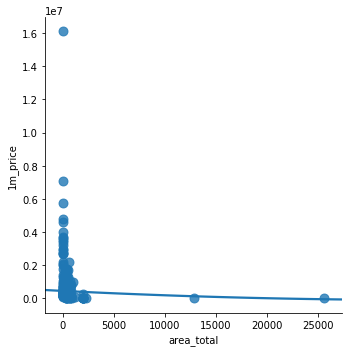

In [17]:
#fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(20,15))
area_and_price = cities_data[['area_total', '1m_price']].groupby('area_total').mean().reset_index()

sns.lmplot(x="area_total", y="1m_price", data=area_and_price,
           order=2, ci=None, scatter_kws={"s": 80});

In [18]:
cities_data['1m_price'].quantile(0.75)

373684.2105263158

In [19]:
cities_data[cities_data['1m_price'] < cities_data['1m_price'].quantile(0.99)]

,id,date,city,address,lat,lon,price,view_count,room_count,image_count,...,inet_type,furniture,floor_type,security,priv_dorm,parking,room_height,complex,is_pledged,1m_price
5,27800002,08.01.2018,"Алматы, Ауэзовский р-н",Саина — Толе би,43.239481,76.838386,9500000,85,1,1,...,NaN,NaN,линолеум,домофон,нет,NaN,NaN,NaN,0,237500.000000
20,27904159,06.01.2018,"Алматы, Бостандыкский р-н",Жарокова — Басенова,43.222305,76.901638,16000000,45,2,4,...,NaN,NaN,линолеум,NaN,нет,NaN,NaN,NaN,0,313725.490196
21,27904158,06.01.2018,"Алматы, Ауэзовский р-н",мкр Аксай-1А 25,43.240906,76.824018,10000000,4,1,0,...,NaN,пустая,линолеум,"домофон, видеонаблюдение",нет,NaN,NaN,НИКО по Момышулы - Райымбека,0,263157.894737
22,27904157,06.01.2018,"Алматы, Алмалинский р-н",Шафик Чокина (Мирзояна) 116 — Казыбек би (Сове...,43.255570,76.910161,13350000,12,2,7,...,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,0,317857.142857
23,27904156,06.01.2018,"Алматы, Алмалинский р-н",Райымбека — Байзакова,43.264131,76.902732,16300000,8,2,6,...,ADSL,частично меблирована,линолеум,NaN,нет,NaN,2.7,NaN,0,326000.000000
24,27904155,06.01.2018,"Алматы, Ауэзовский р-н",Юрия Кима (Студенческая) 8 — Саина,43.253937,76.911429,12800000,1,2,0,...,NaN,частично меблирована,линолеум,NaN,нет,NaN,2.6,NaN,0,278260.869565
25,27904152,06.01.2018,"Алматы, Бостандыкский р-н",Навои — Торайгырова Султанмахмуда (Фрунзе),43.249329,76.895256,19000000,2,1,9,...,NaN,NaN,NaN,NaN,нет,NaN,NaN,NaN,0,441860.465116
26,27904151,06.01.2018,"Алматы, Ауэзовский р-н",Алтынсарина — Абая,43.225885,76.865919,9800000,17,1,3,...,ADSL,NaN,линолеум,домофон,нет,рядом охраняемая стоянка,NaN,NaN,0,306250.000000
28,27904145,06.01.2018,"Алматы, Бостандыкский р-н",Туркебаева 246 — Сатпаева,43.234904,76.881424,11350000,9,1,5,...,NaN,NaN,линолеум,NaN,нет,NaN,NaN,NaN,0,338805.970149
29,27904144,06.01.2018,"Алматы, Ауэзовский р-н",Жубанова 65 — Алтынсарина (Правды),43.233209,76.851142,13300000,13,2,8,...,NaN,NaN,линолеум,NaN,нет,NaN,NaN,NaN,0,289130.434783


In [20]:
cities_data['date'].unique()

array(['08.01.2018', '06.01.2018', '07.01.2018', '05.01.2018',
       '04.01.2018', '03.01.2018', '02.01.2018', '01.01.2018',
       '14.01.2018', '13.01.2018', '12.01.2018', '11.01.2018',
       '10.01.2018', '09.01.2018', '15.01.2018', '17.12.2017',
       '16.12.2017', '15.12.2017', '14.12.2017', '13.12.2017',
       '12.12.2017', '19.12.2017', '11.12.2017', '18.12.2017',
       '25.12.2017', '24.12.2017', '23.12.2017', '22.12.2017',
       '21.12.2017', '20.12.2017', '27.12.2017', '26.12.2017',
       '10.12.2017', '09.12.2017', '08.12.2017', '07.12.2017',
       '06.12.2017', '05.12.2017', '31.12.2017', '30.12.2017',
       '29.12.2017', '28.12.2017', '28.01.2018', '27.01.2018',
       '26.01.2018', '25.01.2018', '24.01.2018', '23.01.2018',
       '22.01.2018', '29.01.2018', '21.01.2018', '19.01.2018',
       '20.01.2018', '18.01.2018', '17.01.2018', '16.01.2018',
       '04.12.2017', '03.12.2017'], dtype=object)